# Understanding Etsy Reorders

Authors: Carlo Colizzi, Andrew Kurtz

# Introduction

Andrew has been running a stationery and greeting card business on Etsy for the past 4 years.
During this time, he was able to fulfill thousands of orders, and now would like to understand
what pushes customers to order again, in an attempt to increase customer retention. To put it simply, we are trying to figure out what are the characteristics of repeat customers. 

We will try to do this by analyzing the order data obtained through the Etsy API, looking specifically
at how often and when customers reorder, as well as the general characteristics of those orders (order size, etc...).

Acquiring new customers is time-consuming and expensive. Therefore, figuring out how to what drives
customer loyalty and improving that would be an easy path for growth. For example, if many customers
reorder for specific occasions as gifts (Mother's Day, Christmas, etc), then sending out targeted
marketing to past customers around those events would be an efficient way to retain customers.

To make sure the code runs correctly, run the cell below:

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter
import pandas as pd
import statistics
from datetime import datetime

from api_lib import get_all_orders, read_json, extract_data
from analyze_data import calculate_avg_order_size, calculate_orders_per_customer, calculate_reorder_rate_by_state, calculate_time_between_orders, count_orders_by_state, find_order_dates


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Methodology
## Obtaining the Data

To access the data we requested access to the Etsy API to get an initial access key and credentials from Etsy, then went through the authentication steps to connect it to Andrew's Etsy shop to get updated keys that enable access the private order and review data from the shop.

Using those keys we wrote a python library in the file `api_lib.py` to pull all of the orders and reviews and save them as JSONs. For each order, the API gives us all relavant details including user ID information, shipping detials, all the items in order, total value, and date/time placed. In our analysis only need a fraction of the data. These are the key data points we use from orders:

- `buyer_user_id`: Integer thats a unique identifying id used to keep track of buyers to determine repeat customers
- `create_timestamp`: Unix timestamp for when order was created
- `state`: String with state name abbreviation from shipping address
- `subtotal`: Dictionery with keys:
    - `amount`: Order subtotal amount as int
    - `divisor`: Int representing what value to divide `amount` by to get dollar amount

From the reviews dataset, we only accessed the `buyer_user_id` value which represents the same thing as `buyer_user_id` in the order dataset.

To pull the data and save it locally, we ran the cell below with two functions from our api_lib.py library. We only needed to run this at the beginning and after a few days has passed to update the data with the latest orders. By saving it locally, we can mitigate calls to the API.

In [21]:
# KEY_PATH = "keys.json"
# ORDERS_PATH = "orders.json"
# SHOP_ID = 23574688

# get_all_orders(KEY_PATH, ORDERS_PATH, SHOP_ID)

This cell is used to read the locally stored order and review data, storing them in their respective variables as lists of dictionaries.

In [22]:
orders = read_json('orders.json')

To pull the specific data points mentioned above, we wrote a function called 'extract_data' which extracts the data from all orders stored in parameter_1 and optionally parameter_2 and returns a list. This function will be used throughout the essay.

## Processing the data
### Number of customers who reorder
In the first step of our analysis, we decided to understand the split between one-off customers and returning customers. We did this by writing a function that takes all customer ids from all orders, stores them in `buyer_user_id`, and uses a `Counter()` function to check which ones appear multiple times. Diving into the function, you can notice one customer id has been removed. This is because that account in particular was an account used to place test orders, and therefore would skew the data. Once we knew how many orders were repeat orders, and how many were one-off, we were able to represent this on a chart.

In [23]:
buyer_user_id, num_reorders, num_customers = calculate_orders_per_customer(orders)

### Order size

We then decided to look into the average order size, to see if there were any possible patterns between the average expense of a single vs repeating order. In order to do this, we matched the order amounts to the customer id, and then divided these into two groups: `multiple_order_customers` and `single_order_customers`. Once we had these two lists, we were able to calculate the arithmetic mean of the amount of money spent on orders. 

In [24]:
single_order_value, multiple_order_value = calculate_avg_order_size(buyer_user_id, orders)

### Time between reorders

We then decided to delve into the time side of the question. Firstly, we needed to convert the UNIX timestamp into a format that could easily be worked with and understood by humans. Again, we used the customer id to identify which were repeat orders, this time paired with the `order_time`. After matching with customer id, we iterated through the dictionary, taking the time difference between orders where this existed. As the time delta was in days, we converted this to years to make it easier to understand.

In [25]:
years, orders_by_customer = calculate_time_between_orders(buyer_user_id, orders)

### Dates of Reorders

Noticing that most reorders occurred at 1 year intervals, we wanted to better understand what the occasions were, and more specifically, whether they were country-wide holidays like Christmas and the Fourth of July, or person-specific dates such as birthdays. After dividing customers by single or repeat orders, we iterated over these groups individually to tally the months at which the orders occured. 

In [26]:
single_by_month, multiple_by_month = find_order_dates(orders_by_customer)

### Number of orders by state

After looking into when the orders occurred, we were interested in the 'where'. Using the data obtained through the Etsy API, we isolated the states to which the orders were shipped, and compounded a dictionary that counted how many orders were placed for each state. 

In [27]:
state_list = count_orders_by_state(orders)

### Repeat order rate by state

As our objective was to identify patterns in reorders, we had to repeat the above, this time making a distinction between single and multiple orders. We decided the best way to do this was to calculate for each state a percentage of returning customers, assessed by a percentage of reorders compared to total orders coming from each state. To do this, we created a function that creates a dictionary havign states as keys, and then proceeds to fill this dictionary with customer ids of orders placed in that state. After this, we count how many times customer ids appear in a given state, and use this value to calculate how many customers ordered more than once. However, it is important to notice that this was done only for states where the total number of customers exceeds 20, as a sample pool any smaller than that would be too small to draw reasonable conclusions from.

In [28]:
state_reorder_df = calculate_reorder_rate_by_state(orders)

# Results

## Visualizing Data

### Understanding the number of customers that reorder
For our first visualization we wanted to see the distribution of how the number of orders customers place to gain a general understanding of the repeat order rate. This will also help give context to the rest of the essay of how many customers are in the category of repeat customers.


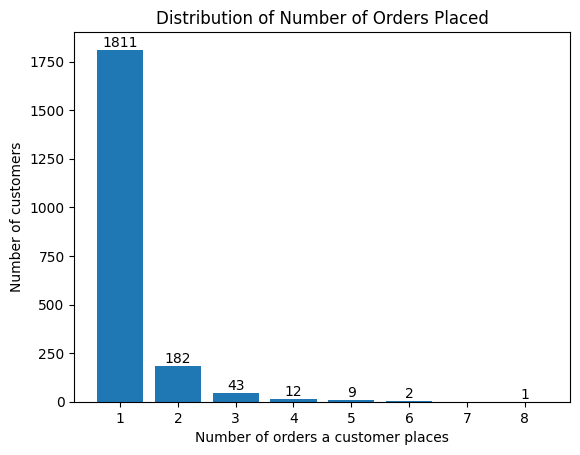

In [29]:
labels = [str(item) for item in list(num_customers)]

fig, ax = plt.subplots()
bars = ax.bar(num_reorders, num_customers, label=labels)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel("Number of orders a customer places")
plt.ylabel("Number of customers")
plt.title("Distribution of Number of Orders Placed")

plt.show()

This visualization shows that the vast majority of customers are single order, a few place two orders, fewer place three, and so on. There are many factors from a business and branding perspective that could account for the low repeat customer rate. The first is that customers are unsatisfied with the product, but that is unlikely because 590 of the 600 reviews are five stars. Another potential factor is that customers aren't attached to my brand specifically, but rather the platform Etsy as a whole. This would mean that when they want to order more stationery, they won't go to Andrew's Etsy shop specifically, but rather search the whole platform and ultimetely order from a different shop.

While the majority of customers don't repeat, there is a group of loyal customers who repeat order many times. This is seen in the data by 43 customers who order 3 times, 12 who order 4 times, 9 who order 5 times, and a few who have ordered even more than that. This suggests that brand loyalty does exist, but at low rates and through increased branding it is possible to grow these numbers more.

### Order Size

With a general understanding of how many customers reorder, we wanted to better understand if there was a difference in size of customers who reorder vs not. For example, maybe repeat customers tend to place more smaller orders. These results could influence the value of trying to attract more repeat customers because if they place small orders on average our time may be more effectively spent attracting new higher value customers.

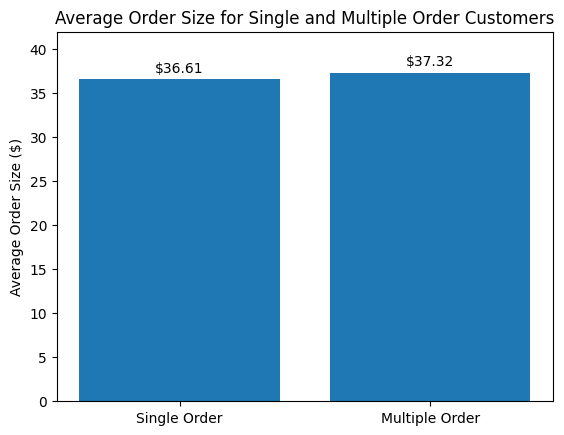

In [30]:
fig, ax = plt.subplots()

labels = ["Single Order", "Multiple Order"]
amounts = [single_order_value, multiple_order_value]

bars = ax.bar(range(len(labels)), amounts, align='center')
ax.set_xticks(range(len(labels)), labels=labels)
ax.bar_label(bars, padding=3, label_type='edge', fmt='$%.2f')
ax.set_ylabel('Average Order Size ($)')
ax.set_title('Average Order Size for Single and Multiple Order Customers')
ax.set_ylim(0, 42)

plt.show()

From this plot we can see that multiple order customers place marginally higher orders on average, but it isn't statistically significant. This is interesting because it disproves the theory that Andrew has seen anecdotally that repeat customers tend to place smaller orders. This means that it is worth trying to increase the repeat order rate becuase they are just as valuable as one offs. 

### Time between re-orders

Another characteristic of repeat customers that we wanted to observe was the time difference between repeat orders. Do people typically wait to run out or reorder or reorder right away? Finding this out could help us inform the decision on how long after they order to market to past customers. We decided to visualize this as a Violin plot so that we could see the trends of the density of repeat orders with each spacing in a continuous manner without needing to choose bins for a histogram.

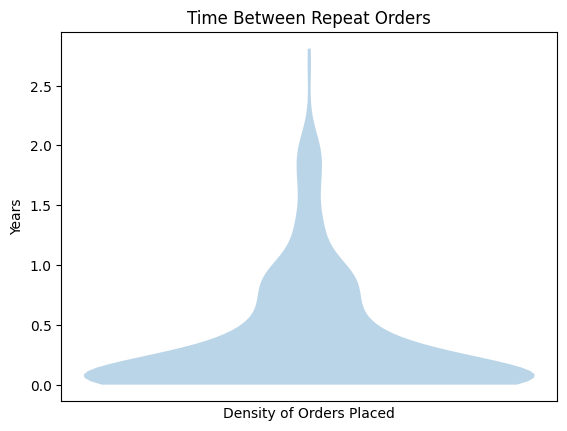

In [31]:
plt.violinplot(years, showmeans=False, showmedians=False,showextrema=False)
plt.ylabel('Years')
plt.xlabel('Density of Orders Placed')
plt.title('Time Between Repeat Orders')
plt.xticks([])
plt.show()

The plot shows that most of the repeat orders take place within a few months of the previous order, but there is also a bump around 9-12 months and two years. This suggests that the most effective marketing would be done at those increments after the first order is placed. This way it wouldn't be necessary to spam a customer because we have the data for precision targeted marketing.

### Understanding the dates of reorders

Since we noticed a bump at around 1 and 2 years we wondered what could possibly cause this. One answer that came to mind fairly quickly was holidays and birthdays. To unpack the data further to answer this question we thus decided to look at the distribution of orders from single order and repeat order customers based on time of year. This way we could see trends around holidays.

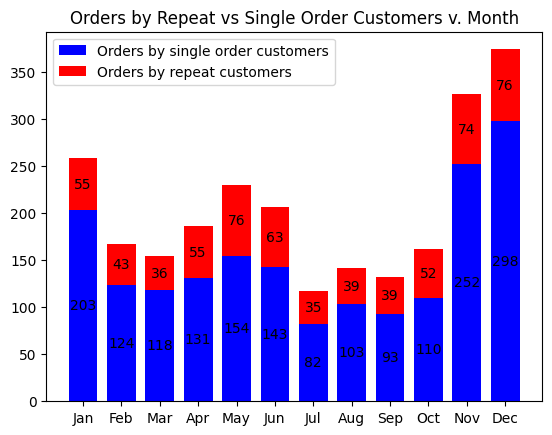

In [32]:
months_abbreviations = [
    "Jan", "Feb", "Mar", 
    "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", 
    "Oct", "Nov", "Dec"
]

fig, ax = plt.subplots()
bottom = 12

width = .75

for index in range(12):
    p = ax.bar(months_abbreviations[index], single_by_month[index], width, bottom=0, color='blue')
    q = ax.bar(months_abbreviations[index], multiple_by_month[index], width, bottom=single_by_month[index], color='red')

    ax.bar_label(p, label_type='center')
    ax.bar_label(q, label_type='center')

ax.set_title('Orders by Repeat vs Single Order Customers v. Month')
ax.legend(['Orders by single order customers', 'Orders by repeat customers'])

plt.show()

Looking at the data there are a few key trends to take stock of. The first is that repeat customers tend to place the most orders in May and June and November and December. This confirms our hypothesis that customers place the most repeat orders around holidays/occasions. In May/June one of the main reasons to order personalized stationery is graduation gifts/thank you notes and November/December is of course Christmas gifts. This can help further inform marketing to suggest increase efforts in graduation season and the holidays.

Another trend to note is that there is a significant number of single order customers that order around the holidays. Combining this finding with the finding of the previous graph that many repeat customers order within a few months after their previous order means that an effective strategy to turn these buyers into repeat customers would be increasing marketing targeting these first time customers in January, February, and March.

### Orders per state

Analyzing the time orders occurred at made us curious about exploring where these orders were occurring and if certain parts of the country had a higher repeat order rate. Using the data pulled using the Etsy API, we plotted the shipping addresses to see what countries were most common. However, we quickly realised all but 3 orders occurred within the USA. Thus, we decided to narrow down our search, to plot what states orders came from. 

We first started by plotting the number of orders shipped to each state to get a broad geographic understanding before focusing on repeat customers. It is important to note that since Texas has such a large number of orders (250 compared 160 being next highest), we scaled the colors so that 150+ is the darkest shade of green to enable more contrast between the rest of the states. 

In [33]:
fig = px.choropleth(state_list, locationmode = 'USA-states', locations='state', color='number_of_orders',
                        color_continuous_scale="Greens",
                        range_color=(0, 150),
                        scope="usa",
                        labels={'number_of_orders':'Number of Orders'},
                        )
fig.update_layout(title_text = 'Number of Orders by State', geo_scope='usa', margin={"r":20,"t":80,"l":0,"b":30})
fig.show()

The graph shows that bulk of the customers are in the eastern half of the US, Texas, Colorado, and California. Among the Eastern US, the South is the strongest, but there are still strong sales in the mid-atlantic region and Massachussets. It is interesting that there are only three states west of the Mississippi with meaningful numbers of sales. Colorado makes sense Since Andrew is from there, so it has a large number of orders due to family/friends. It also makes sense that Texas is far and away the biggest state in terms of sales because it still has the more traditional southern culture, but also has a huge population. That leaves California as a geographic outlier. 

This data is useful because it can inform decisions about what markets to expand into and designs to make. For example, since Texas is the biggest state, it would make sense to design a Texas themed pack of stationery.

### Repeat order rate by state
With the geographic distribution of the orders in mind, we created a map of the percent repeat customers in each state. To ensure a more accurate visualization, we filtered out the states with fewer than 20 customers. This prevents cases where a state may only have a few customers, so if one of them reorders the reorder rate is articially high. 

In [34]:
maximum_color_percent = 20
fig = px.choropleth(state_reorder_df, locationmode = 'USA-states', locations='state', color='reorder_rate',
                        color_continuous_scale="Greens",
                        range_color=(0, maximum_color_percent),
                        scope="usa",
                        labels={'reorder_rate':'Percent Repeat Customers by State'},
                        )
fig.update_layout(title_text = 'Percent Repeat Customers by State', geo_scope='usa', margin={"r":20,"t":80,"l":0,"b":30})
fig.show()

In contrast to map with orders by state, there aren't any obvious trends in which states have a higher reorder rate. Perhaps this is because even when exluding states with fewer than 20 orders, a single additional repeat order would move the repeat rate by half a percent to a few percentage points depending on how many total orders received. So while New Jersey may seem like an outlier in that it has an 18% reorder rate, it may be a statistical anomoly because two extra customers randomly decided to reorder. 

Furthermore, because the scale is between 0 and .2, these small differences are amplified. If you adjust the variable 'maximum_color_percent' at the beginning of the visualization code to a higher number such as 1, it makes it look like there is little statistical difference between the values. It is hard to know which scale is appropriate to use because a few percent difference, is more than a 10% difference in reorder rates between states which is significant. 

Combining the effect of amplificiation the relatively small sample size for each state means we don't have statistically meaningful data to allow us to draw effective conclusions on state reorder rate from the data.

# Conclusion

### Findings
There are a few key insights from this project that are both interesting to consider from a sociological and business standpoint. The first is that the customer retention rate is relatively low at about 12% which is 249 of 2060 customers. We found repeat customers are just as valuable as new customers becuase they place similar sized orders on average, so it is worth trying to increase thisr rate. To do so, we identified a key strategy for targeted marketing based on repeat customer habits. We found that most reorders occur within a few months or at 1 and 2 year increments. There is also a higher number of repeat orders around graduation season and the holidays. An effective marketing strategy using this data that Andrew can implement going forwards is to email customers who opt into marketing at 1, 2, 11, and 24 increments months after their first order and during graduation and the holidays. This way Andrew could send targeting effective marketing and could avoid spamming customers. 

### Lessons
An important lesson more broadly from the essay is considering framing visualization carefully and determining which findings are statistically significant. In the last section on repeat order rates by state, the scale we used between 0 and 20% which can have an amplification effect making findings look more significant then they are. While there are valid reasons to use a scale like this, it needs to be taken into consideration when determining the significance of results as we did to conlcude that in this case they weren't significant.

### Ethics
For the most part, this project creates no ethical concerns. However, it is important to notice that some sensitive data is used for the geographical analysis, such as states. While states per se are not someting that can identify a specific person, they can be used along with other data to do so. Furthermore, while we chose not to use the full address of people, it is also important to notice that the API does provide this data if requested. Therefore, there is a potential for misuse of this sensitive data.

Another ethical consideration is in who to market to using these insights. While the customers email are among the data Andrew has access to, it isn't ethical or legal to send them marketing emails without their consent. In order to implement these findings, Andrew will set up a system to opt into emails incentivized by recieving a coupon. He will also make sure it is easy to unsubscribe and that it results in a permanent removal from the email list.

### Challenges
One of the most frustrating parts of the project was creating the interactive map graphs. This is because they were created using a library that neither of us have used before, and therefore knew nothing about. Furthermore, another challenging part of this project was obtaining the API data. API calls were new for both of us, and the specific syntax and error codes were difficult to understand at first. This is why we initially thought of using a separate library to write the API calls, but abandoned this idea to maintain the overall structure of the project simpler. 

### Assumptions and Future Improvements

One assumption we made when analyzing repeat orders was that all customers only used a singular account to order. This assumption doesn't hold up in reality because sometimes customers forgete they already have an account or somehow lose access. This effect is likely minimal, but it would slightly decrease the repeat order rate.

Another assumption we made when analyzing the goegraphic data was that the shipping address is in the same state that the order was placed from. This isn't always the case because of gifts to other states among other reasons. This slightly skews the, but is unlikely to change the larger trends.

If we had more time, we believe it would be useful to dive deeper into the psychology of the customer, understanding exactly what elements drive a customer to reorder. We could analyze other demographics such as estimated age based on name or estimated income based on zip code. We could also look into if different products have a higher retention rate. It could also be very interesting to assess the success of different customer retention techniques outlined here or others, such as newsletters, promo codes, sales, bundles, or else. 